# ADALM-PLUTO + Python MPSK Modulation and Demodulation Tutorial

This tutorial demonstrates how to use ADALM-PLUTO and Python to perform MPSK (M-ary Phase Shift Keying) modulation and demodulation for communication. We will go through the setup, data generation, modulation, transmission, reception, synchronization, and symbol error rate (SER) analysis.

---

## 1. Environment Setup and ADALM-PLUTO SDR Configuration

### 1.1 Install Required Libraries & Import Libraries

To interact with ADALM-PLUTO via Python, install the `pyadi-iio` package:

```bash
pip install pyadi-iio


In [118]:
import numpy as np
import adi # ADALM-PLUTO SDR interface library
import matplotlib.pyplot as plt
import scipy.signal as signal

### 1.2 ADALM-PLUTO SDR Setup

Now, let's configure the ADALM-PLUTO SDR for transmission and reception

In [119]:
# Connect to ADALM-PLUTO using its IP address
sdr = adi.Pluto("ip:192.168.2.1")  # Replace with your Pluto's IP address

# Configure Transmitter (TX)
sdr.tx_rf_bandwidth = int(1e6)  # Set TX bandwidth to 1 MHz
sdr.tx_lo = int(915e6)  # Set TX frequency to 915 MHz
sdr.tx_hardwaregain_chan0 = -30  # Set TX gain (in dB)

# Configure Receiver (RX)
sdr.rx_lo = int(915e6)  # Set RX frequency to the same as TX
sdr.rx_rf_bandwidth = int(1e6)  # Set RX bandwidth to 1 MHz
sdr.rx_buffer_size = 10000  # Set RX buffer size
sdr.gain_control_mode_chan0 = 'manual'  # Set RX gain mode to manual
sdr.rx_hardwaregain_chan0 = 0  # Set RX gain (0 dB)

# Generate random data to transmit
samples = np.random.randn(1000)  # Generate random samples between -1 and 1

# Scale the samples to be within the ADALM-PLUTO's input range of -2^14 to +2^14
samples *= 2**14  # Scale the samples

# Start Transmitting Data
sdr.tx_cyclic_buffer = True  # Enable cyclic buffer for continuous transmission
sdr.tx(samples)  # Transmit the scaled samples

# Receive samples
rx_samples = sdr.rx()  # Get the received samples

# Stop Transmission
sdr.tx_destroy_buffer()  # Clean up the TX buffer

#### Explanation of the Code

- **ADI Library**: `adi` is used to interface with the ADALM-PLUTO SDR. It provides methods for configuring and controlling the hardware, including transmission (TX) and reception (RX).
- **TX and RX Configuration**: The code sets the transmission and reception properties such as the radio frequency (`tx_lo` and `rx_lo`), bandwidth (`tx_rf_bandwidth` and `rx_rf_bandwidth`), and hardware gain (`tx_hardwaregain_chan0` and `rx_hardwaregain_chan0`).
- **Transmission**: 
    - The signal to be transmitted is generated randomly (`samples = np.random.randn(1000)`) using `numpy`, which produces values between -1 and 1.
    - Since ADALM-PLUTO expects the transmission signal to be in the range of $(-2^{14})$ to $(2^{14})$ (i.e., values between $(-16384)$ and $(16384)$, we scale the signal by multiplying it by \(2^{14}\):  
    ```python
    samples *= 2**14  # Scale the samples to be within the ADALM-PLUTO's range
    ```
    - The `sdr.tx_cyclic_buffer = True` line enables continuous transmission of the signal by cycling the buffer.
- **Reception**: The received signal is obtained using `rx_samples = sdr.rx()`. The receiver will capture the signal transmitted through the ADALM-PLUTO hardware.
- **Cleanup**: After transmission, we clear the transmission buffer with `sdr.tx_destroy_buffer()` to stop transmitting and free up resources.

This section sets up the ADALM-PLUTO for both transmission and reception, ensuring the transmitted signal is scaled correctly for the hardware.


## 2. MPSK Modulation & Demodulation

In this section, we will implement MPSK (M-ary Phase Shift Keying) modulation and demodulation. MPSK is a method of encoding data by varying the phase of the carrier signal. The data symbols are mapped to distinct phases of the signal.

### 2.1 MPSK Modulation Function

We will generate random data and map them to MPSK symbols. The modulation order $( M )$ determines the number of distinct phase shifts used in the modulation. For example:
- $( M = 2 )$ for BPSK (Binary Phase Shift Keying)
- $( M = 4 )$ for QPSK (Quadrature Phase Shift Keying)
- $( M = 8 )$ for 8-PSK, and so on.

In [120]:
def generate_data_and_mpsk_modulation(M, num_symbols):
    np.random.seed(0)  # Set seed for reproducibility
    # Generate random data symbols from 0 to M-1
    data = np.random.randint(0, M, num_symbols)
    # Map data to phases for MPSK modulation
    phase = data * 2 * np.pi / M + np.pi / M  # Phase shift for each symbol
    symbols = np.cos(phase) + 1j * np.sin(phase)  # Complex MPSK symbols

    return data, symbols

#### Explanation of MPSK Modulation Code

The function `generate_data_and_mpsk_modulation(M, num_symbols)` is responsible for generating MPSK symbols. Here's a breakdown of how the code works:

- **Random Data Generation**:
    - We first generate random data values in the range $(0)$ to $(M-1)$, where $(M)$ is the modulation order (e.g., 2 for BPSK, 4 for QPSK, etc.).
    - This is done using `np.random.randint(0, M, num_symbols)`, which generates an array of random integers representing the transmitted symbols.

    ```python
    data = np.random.randint(0, M, num_symbols)
    ```

- **Phase Mapping**:
    - The key feature of MPSK modulation is the mapping of data symbols to distinct phases. Each data symbol corresponds to a specific phase shift, which is calculated as:
    $[
    \text{phase} = \frac{2\pi \times \text{data}}{M} + \frac{\pi}{M}
    ]$
    - The phase values are scaled to fit within the range of $(0)$ to $(2\pi)$, depending on the modulation order $(M)$. The $(\pi/M)$ offset is added to prevent phase ambiguity (this shifts the phases to avoid a zero-phase reference).
    
    ```python
    phase = data * 2 * np.pi / M + np.pi / M
    ```

- **Complex MPSK Symbols**:
    - After calculating the phase values for each symbol, we use these phases to generate the corresponding complex MPSK symbols.
    - The real part of the symbol is calculated as `np.cos(phase)` and the imaginary part as `np.sin(phase)`. This results in complex values that represent the transmitted MPSK symbols.


#### Example: MPSK Symbol Constellation for M = 4

We will visualize the symbol constellation for **M = 4** (QPSK modulation), which uses four distinct phases for encoding data. The QPSK constellation diagram shows how the symbols are arranged in the complex plane.

For QPSK, the four symbols are mapped to the following phases:
- $( 0^\circ )$ (corresponding to symbol 0)
- $( 90^\circ )$ (corresponding to symbol 1)
- $( 180^\circ )$ (corresponding to symbol 2)
- $( 270^\circ )$ (corresponding to symbol 3)

The symbols are plotted on the unit circle in the complex plane, where the real part corresponds to the in-phase component and the imaginary part corresponds to the quadrature component.

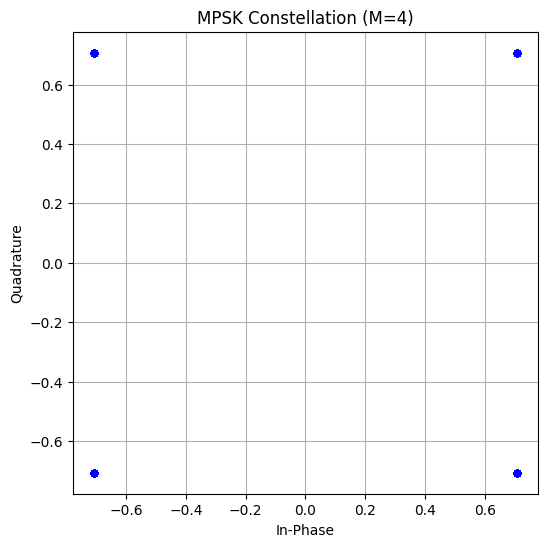

In [121]:
# Parameters for QPSK modulation
M = 4  # Modulation order (QPSK)
num_symbols = 1000

# Generate data and modulate using MPSK
data, symbols = generate_data_and_mpsk_modulation(M, num_symbols)

# Plot the MPSK constellation diagram
plt.figure(figsize=(6, 6))
plt.scatter(np.real(symbols), np.imag(symbols), color='blue', s=20)
plt.title(f'MPSK Constellation (M={M})')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.show()

### 2.2 MPSK Demodulation

The function `mpsk_demodulation` is designed to demodulate the received MPSK signal based on its phase information. It compares the phase of the received signal with reference phase values corresponding to each symbol in the MPSK constellation. The closest symbol is selected as the decoded data.

In [122]:
def mpsk_demodulation(rx_signal, M):
    phase = np.angle(rx_signal)  # Get the phase of the received signal
    reference = (np.arange(0, M) * 2 * np.pi / M) + np.pi / M  # Reference phases
    reference[reference > np.pi] -= 2*np.pi  # Normalize phase to [-pi, pi]
    distances = np.abs(phase[:, np.newaxis] - reference[np.newaxis, :])  # Compute distance from reference phases
    rx_data = np.argmin(distances, axis=1)  # Find closest symbol in phase

    return rx_data

#### Explanation of MPSK Demodulation Code

- **Input**: The function takes two parameters:
  - `rx_signal`: The received signal, which is expected to be a complex array representing the signal.
  - `M`: The modulation order (e.g., M = 2 for BPSK, M = 4 for QPSK, etc.).
- **Phase Extraction**: The phase of the received signal is extracted using `np.angle()`. This gives the angle (or phase) of each complex symbol in the received signal.
- **Reference Phases**: We create reference phases for the MPSK constellation, which are uniformly spaced from 0 to 2π. These reference phases represent the ideal positions of each symbol in the MPSK constellation.
- **Distance Calculation**: For each received symbol, we compute the distance (phase difference) between its phase and the reference phases of the MPSK symbols. This is done by subtracting the reference phases from the received phase and finding the absolute value of the result.
- **Symbol Selection**: For each received symbol, the function selects the reference phase that is closest to its phase. The index of the closest reference phase corresponds to the decoded symbol.


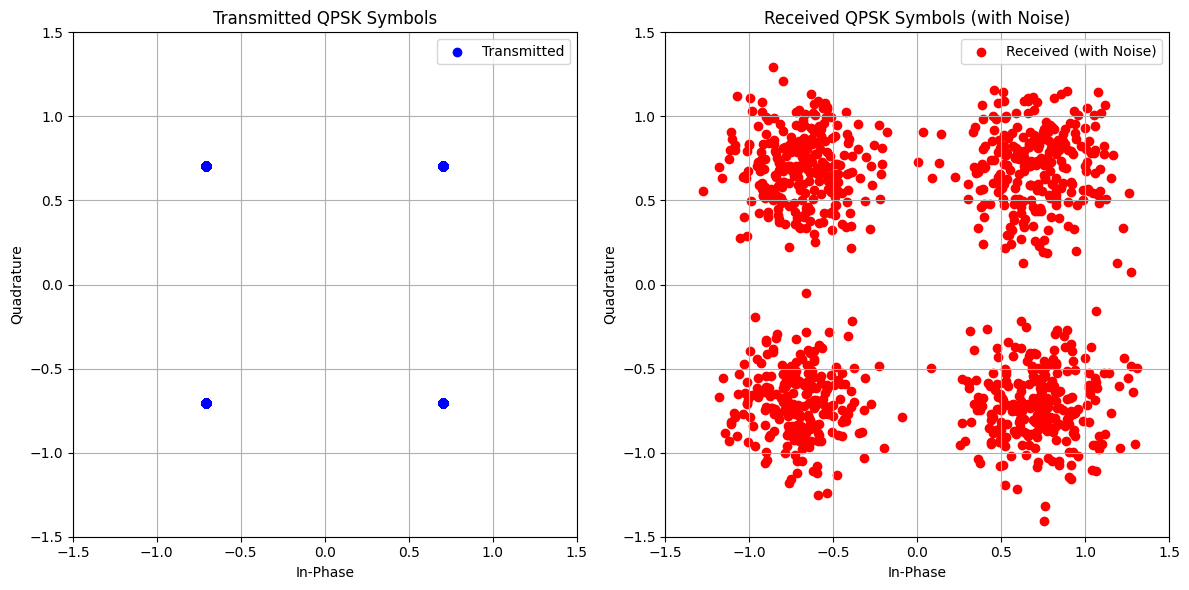

Transmitted data (first 10 symbols): [3 2 3 0 0 2 3 0 3 1]
Received data (first 10 symbols): [3 2 3 0 0 2 3 0 3 1]


In [123]:
# Example parameters
M = 4  # QPSK modulation (4 symbols: 0, 1, 2, 3)
num_symbols = 1000  # Number of symbols
SNR_dB = 10  # Signal-to-noise ratio in dB

# Modulate random data (for example, QPSK)
data = np.random.randint(0, M, num_symbols)  # Random data
phase = data * 2 * np.pi / M + np.pi / M  # Map data to phases
tx_signal = np.cos(phase) + 1j * np.sin(phase)  # QPSK symbols

# Add Gaussian noise to the signal
noise_power = 10 ** (-SNR_dB / 10)  # Calculate noise power from SNR
noise = np.sqrt(noise_power / 2) * (np.random.randn(num_symbols) + 1j * np.random.randn(num_symbols))  # Complex Gaussian noise
rx_signal = tx_signal + noise  # Received signal = transmitted signal + noise

# Demodulate the received signal
rx_data = mpsk_demodulation(rx_signal, M)

# Plot the transmitted and received signals
plt.figure(figsize=(12, 6))

# Plot transmitted signal (in phase vs. quadrature form)
plt.subplot(1, 2, 1)
plt.scatter(np.real(tx_signal), np.imag(tx_signal), color='blue', label='Transmitted')
plt.title('Transmitted QPSK Symbols')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.legend()
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

# Plot received signal (in phase vs. quadrature form)
plt.subplot(1, 2, 2)
plt.scatter(np.real(rx_signal), np.imag(rx_signal), color='red', label='Received (with Noise)')
plt.title('Received QPSK Symbols (with Noise)')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.grid(True)
plt.legend()
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

plt.tight_layout()
plt.show()

# Compare transmitted and received data
print("Transmitted data (first 10 symbols):", data[:10])
print("Received data (first 10 symbols):", rx_data[:10])


## 3. Synchronization and Channel Estimation

In this section, we focus on the techniques used for **synchronizing** the received signal with the transmitted signal and performing **channel estimation**. Synchronization ensures that the receiver can correctly detect the beginning of the transmitted symbols, and channel estimation helps to mitigate distortions introduced by the communication channel.

We use a **Zadoff-Chu sequence** as the synchronization signal. Zadoff-Chu sequences are known for their good autocorrelation properties, which make them ideal for use as preambles in wireless communication systems. These sequences are widely used in systems like LTE for synchronization purposes.

Additionally, we assume a **one-tap channel model** for channel estimation, meaning that we estimate a single complex gain factor that represents the overall distortion from the transmitter to the receiver. This simple model is often used in practice when the channel remains relatively stable over the duration of the transmission.

### 3.1 Zadoff-Chu Synchronization Signal

The Zadoff-Chu sequence is a sequence of complex values with constant amplitude and specific phase properties that provide good correlation characteristics. This makes it easy for the receiver to find the synchronization point in the received signal.

#### Zadoff-Chu Sequence Generation:
The Zadoff-Chu sequence can be generated using the following formula:

$[
x(n) = \exp\left(-j \frac{\pi \cdot u \cdot n (n+1)}{N}\right)
]$

Where:
- $( u )$ is the root (a non-zero integer),
- $( n )$ is the index of the sequence (from 0 to $( N-1 )$),
- $( N )$ is the length of the sequence.

#### Key Properties of Zadoff-Chu Sequences:
- **Constant Amplitude**: The sequence has a constant magnitude for all values of \( n \), meaning that the sequence is purely phase-modulated.
- **Good Autocorrelation**: The sequence has a sharp autocorrelation peak, which makes it easy for the receiver to identify the position of the synchronization signal, even in noisy environments.
- **Ideal for Synchronization**: Due to these properties, Zadoff-Chu sequences are highly effective for **time synchronization** and **frequency offset estimation** in communication systems such as LTE and 5G.

#### Why Use Zadoff-Chu?
The primary advantage of Zadoff-Chu sequences is their ability to provide a distinct correlation peak, which allows the receiver to accurately locate the beginning of the transmitted symbols. This is crucial in **synchronization**, where precise timing is required to correctly decode the transmitted data.

The sequence is also robust against Doppler shifts and multipath propagation, which are common in wireless channels. This makes Zadoff-Chu sequences highly suitable for scenarios like satellite communications, where long-range transmission can cause significant frequency shifts and delays.


In [124]:
def generate_sync_signal(N, u):
    """
    Generates a Zadoff-Chu sequence for synchronization.
    
    Parameters:
    - N: Length of the sequence
    - u: Root (non-zero integer)
    
    Returns:
    - Zadoff-Chu sequence (complex values)
    """
    n = np.arange(N)
    sequence = np.exp(-1j * np.pi * u * n * (n + 1) / N)
    return sequence

#### Example: Zadoff-Chu Sequence for N=64, u=29

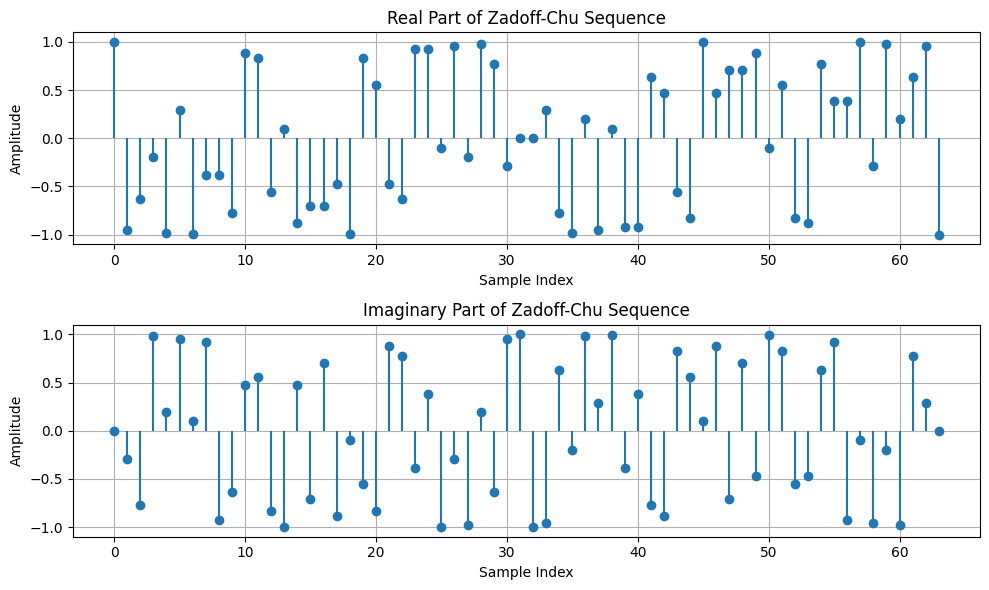

In [125]:
# Parameters for Zadoff-Chu sequence
N = 64  # Length of the sequence
u = 29  # Root for Zadoff-Chu sequence

# Generate the Zadoff-Chu sequence
sync_signal = generate_sync_signal(N, u)

# Create a figure with two subplots for real and imaginary parts
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Plot the real part of the sequence
ax[0].stem(np.arange(N), np.real(sync_signal), basefmt=" ")
ax[0].set_title('Real Part of Zadoff-Chu Sequence')
ax[0].set_xlabel('Sample Index')
ax[0].set_ylabel('Amplitude')
ax[0].grid(True)

# Plot the imaginary part of the sequence
ax[1].stem(np.arange(N), np.imag(sync_signal), basefmt=" ")
ax[1].set_title('Imaginary Part of Zadoff-Chu Sequence')
ax[1].set_xlabel('Sample Index')
ax[1].set_ylabel('Amplitude')
ax[1].grid(True)

plt.tight_layout()
plt.show()


### 3.2 Channel Estimation using the Zadoff-Chu Sequence

In this section, we discuss how to perform **channel estimation** using the **Zadoff-Chu synchronization signal**. Channel estimation is critical in communication systems as it helps the receiver estimate the effects of the communication channel (such as attenuation, delay, and Doppler shift) in order to correctly decode the received signal.

For simplicity, we assume that the channel is a **one-tap channel**, meaning that the channel is assumed to be **flat** across all subcarriers. This approximation makes the channel estimation process simpler, and it is a reasonable assumption in many practical scenarios, especially when the channel is not rapidly varying.

#### Overview of the Channel Estimation Process:
- **Transmit the Zadoff-Chu Sequence**: The Zadoff-Chu sequence is transmitted as a known reference signal.
- **Receive the Signal**: The receiver receives the signal, which is affected by the channel (e.g., attenuation, noise, Doppler shift).
- **Cross-Correlation**: To detect the synchronization signal and estimate the channel, the received signal is cross-correlated with the transmitted Zadoff-Chu sequence.
- **Estimate the Channel**: The peak of the cross-correlation gives the channel estimate. In this case, we assume a **one-tap channel**, which means the channel gain is constant for all symbols.

#### Step-by-Step Process:

- **Generate the Synchronization Signal**: The receiver knows the transmitted Zadoff-Chu sequence and can use it to cross-correlate with the received signal.
   
- **Cross-Correlation**: The received signal is cross-correlated with the Zadoff-Chu sequence to find the time index of the synchronization signal. The peak of the correlation gives the best alignment between the transmitted and received signals.

- **Estimate the Channel**: The value of the correlation at the peak index is taken as the **channel estimate**. Since we assume a **one-tap channel**, the value of the correlation at the peak corresponds to the channel gain.

In [126]:
def sync_and_channel_estimation(rx_samples, sync_signal):
    """
    Perform synchronization and channel estimation using the received samples and the Zadoff-Chu synchronization signal.
    
    Parameters:
    - rx_samples: The received signal (complex values).
    - sync_signal: The transmitted Zadoff-Chu synchronization signal.
    
    Returns:
    - peak_idx: The index of the peak correlation (synchronization point).
    - estimated_channel: The estimated channel gain (one-tap).
    """
    # Cross-correlation of received signal and the synchronization signal
    corr = signal.correlate(rx_samples, sync_signal, mode='full') / len(sync_signal)
    
    # Find the peak index of the correlation (maximum value)
    peak_idx = np.argmax(np.abs(corr))
    
    # Estimate the channel as the value of the correlation at the peak index
    estimated_channel = corr[peak_idx]
    
    return peak_idx, estimated_channel

#### Explanation of the Code

In the provided code, we use cross-correlation to perform synchronization and estimate the channel. Below is a breakdown of each key part of the code:

- **Cross-Correlation**:
   - The code uses the `scipy.signal.correlate()` function to compute the cross-correlation between the received signal (`rx_samples`) and the known synchronization signal (`sync_signal`).
   - Cross-correlation is a measure of similarity between the received signal and the reference signal as a function of the time-lag applied to one of the signals.
   - The result of the correlation is a complex-valued sequence, where the peak corresponds to the alignment between the received and transmitted signals.

- **Normalization**:
   - The result of the correlation is normalized by dividing by the length of the synchronization signal (`len(sync_signal)`). This ensures that the correlation values are not biased by the length of the sequence.

- **Finding the Peak Index**:
   - The `np.argmax(np.abs(corr))` function is used to find the index of the maximum absolute value of the correlation. This index corresponds to the point of best alignment between the transmitted and received signals, also known as the **synchronization point**.
   - This is the point where the Zadoff-Chu sequence is most likely to be found in the received signal.

- **Channel Estimation**:
   - The value of the correlation at the peak index is taken as the **estimated channel**. Since we assume a **one-tap channel**, the channel gain is assumed to be constant across all symbols.
   - The estimated channel is used to compensate for the channel effect on the received signal.

#### Example: Visualizing the Cross-Correlation

It is useful to visualize the cross-correlation result to understand how the synchronization and channel estimation are performed. The plot below shows the correlation between the received signal and the Zadoff-Chu synchronization signal. The peak of the correlation indicates the synchronization point, and the value of the peak represents the channel estimate.

Here’s the code to plot the cross-correlation:

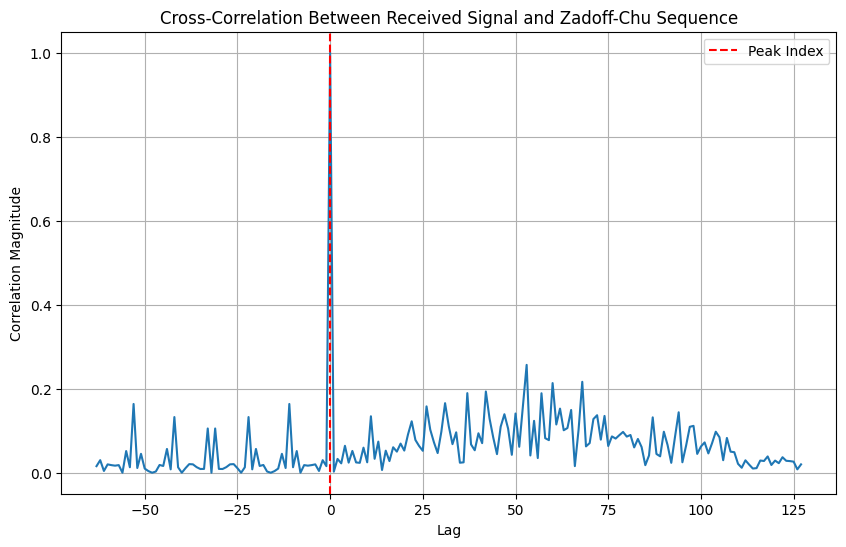

In [127]:
# Example parameters for visualization
N = 64  # Length of the sequence
u = 29  # Root for Zadoff-Chu sequence
sync_signal = generate_sync_signal(N, u)  # Generate Zadoff-Chu sequence
rx_samples = np.concatenate([sync_signal, np.random.randn(N)])  # Simulated received signal with noise

# Perform synchronization and channel estimation
peak_idx, estimated_channel = sync_and_channel_estimation(rx_samples, sync_signal)

# Cross-correlation calculation
corr = signal.correlate(rx_samples, sync_signal, mode='full') / len(sync_signal)

# Adjust the range of x-values to match the length of the correlation
x_vals = np.arange(-len(sync_signal) + 1, len(rx_samples))

# Plot the cross-correlation
plt.figure(figsize=(10, 6))
plt.plot(x_vals, np.abs(corr))
plt.axvline(x=peak_idx - len(sync_signal) + 1, color='r', linestyle='--', label='Peak Index')
plt.title('Cross-Correlation Between Received Signal and Zadoff-Chu Sequence')
plt.xlabel('Lag')
plt.ylabel('Correlation Magnitude')
plt.legend()
plt.grid(True)
plt.show()

#### Explanation of the Plot

The plot visualizes the cross-correlation between the received signal (`rx_samples`) and the Zadoff-Chu synchronization signal (`sync_signal`). The key elements of the plot are explained below:

- **X-axis (Lag)**: The x-axis represents the time lag (or sample index) of the cross-correlation. It spans from `-len(sync_signal) + 1` to `len(rx_samples)` to cover the entire correlation range. The lag values show how much the received signal is shifted relative to the synchronization signal.
  
- **Y-axis (Correlation Magnitude)**: The y-axis represents the magnitude of the cross-correlation at each lag value. This shows how similar the received signal is to the synchronization signal at different shifts (lags). A higher value indicates a closer match.

- **Red Dashed Line**: The red dashed vertical line indicates the **peak index** of the cross-correlation, which corresponds to the best alignment between the received signal and the synchronization signal. This is the point where the synchronization signal is most likely to be found in the received signal.

- **Peak Correlation**: The value of the cross-correlation at the peak represents the estimated **channel gain**. This value is used to compensate for the channel distortion during signal demodulation.

The plot helps to visually understand how the synchronization signal is located in the received signal, and how the channel is estimated based on the correlation result.

### 3.3 Summary

In this step, we performed synchronization and channel estimation using cross-correlation between the received signal and the Zadoff-Chu synchronization sequence. The main steps are summarized below:

- **Synchronization**: The peak of the cross-correlation curve gives the synchronization point, where the received signal best aligns with the known synchronization signal.
  
- **Channel Estimation**: The value at the peak of the cross-correlation is taken as the **estimated channel gain**. We assume a **one-tap channel**, meaning the channel gain is constant across all symbols.

- **Visualization**: By plotting the cross-correlation, we can visually confirm the synchronization point and the accuracy of the channel estimate. The red dashed line marks the synchronization point, and the value at the peak represents the estimated channel gain.

This process is crucial for mitigating the effects of channel distortion and accurately demodulating the received signal in the presence of noise and interference.


## 4. Transmission and Reception of Data

In this section, we focus on the transmission and reception of data using the ADALM-PLUTO SDR and the MPSK modulation scheme. The main steps involved are generating the data, modulating it, transmitting it through the SDR, and receiving it for demodulation. This process is crucial for understanding how data is transferred in a real communication system.


### Transmitting Data through the ADALM-PLUTO SDR

After generating the MPSK symbols, the next step is to transmit these symbols using the ADALM-PLUTO SDR. In this section, we will walk through the process of transmitting data through the SDR. This involves creating the transmit signal, configuring the transmitter and receiver settings, and broadcasting the signal over the air.

#### Key Parameters:
- **Sample Rate**: Defines the rate at which data is sampled (in Hz). This must be set consistently for both transmission and reception.
- **Center Frequency**: The frequency at which the signal is transmitted, typically within the desired communication band (e.g., 915 MHz for this example).
- **Transmit Gain**: The amplification applied to the transmit signal. It should be set to a value that ensures proper signal strength without causing distortion or saturation of the transmitter.
- **Receiver Settings**: Includes configuring the receiver to properly capture and decode the transmitted signal.

In [128]:
def operate_pluto(sample_rate, center_freq, num_samps, tx_gain, rx_gain, samples, num_repeat):
    # Initialize the ADALM-PLUTO SDR
    sdr = adi.Pluto("ip:192.168.2.1")
    sdr.sample_rate = int(sample_rate)
    
    # Configure the transmitter
    sdr.tx_rf_bandwidth = int(sample_rate)  # Set RF bandwidth equal to sample rate
    sdr.tx_lo = int(center_freq)            # Set the center frequency for transmission
    sdr.tx_hardwaregain_chan0 = tx_gain    # Set the transmission gain
    
    # Configure the receiver settings
    sdr.rx_lo = int(center_freq)            # Set receiver center frequency
    sdr.rx_rf_bandwidth = int(sample_rate)  # Set receiver bandwidth equal to sample rate
    sdr.rx_buffer_size = num_samps         # Set the buffer size for received samples
    sdr.gain_control_mode_chan0 = 'manual'  # Set gain control mode
    
    # Start transmission
    sdr.tx_cyclic_buffer = True  # Enable cyclic buffer mode to continuously transmit
    sdr.tx(samples)              # Transmit the generated samples
    
    # Clear buffer to avoid overflow
    for i in range(10):
        raw_data = sdr.rx()
    
    # Receive samples from the SDR
    rx_samples_ = sdr.rx()  # Capture raw samples
    rx_samples = rx_samples_[::num_repeat]  # Resample to match symbol rate
    
    # Stop transmission
    sdr.tx_destroy_buffer()  # Destroy the buffer to stop transmission
    
    return rx_samples

#### Explanation of the Code

In this section, we will explain the code used to transmit and receive data through the ADALM-PLUTO SDR.

- **Initializing the ADALM-PLUTO SDR**: The `adi.Pluto()` function initializes the ADALM-PLUTO SDR by connecting to it via its IP address (`ip:192.168.2.1`). The `sample_rate` and other parameters are set for both the transmitter and receiver.
- **Configure Transmitter**: The transmitter is configured with the sample rate, center frequency, and transmit gain. The `tx_hardwaregain_chan0` parameter controls the transmit power.
- **Configure Receiver**: Similarly, the receiver settings are configured, including the center frequency and RF bandwidth. The `rx_buffer_size` defines the number of samples that can be received at once.
- **Start Transmission**: The `tx(samples)` function sends the modulated data symbols (`samples`) to the transmitter. The `tx_cyclic_buffer` ensures that the transmitter continuously sends data in a loop.
- **Buffer Clearing**: A short loop is used to clear the SDR buffer to prevent overflow and ensure that the receiver can properly capture the transmitted samples.
- **Receive Samples**: After transmission, the `rx()` function is used to receive the signal. We then downsample the received signal by `num_repeat` to match the symbol rate.
- **Stop Transmission**: Finally, `tx_destroy_buffer()` is called to stop the transmission process and free up resources.

## 5. SER for Different TX Gains and MPSK Orders

In [129]:
def calculate_ser(tx_data, rx_data):
    # Calculate the Symbol Error Rate (SER)
    ser = np.sum(tx_data != rx_data) / len(tx_data)
    return ser

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sample_rate = 1e6  # Sample rate (1 MHz)
center_freq = 915e6  # Center frequency (915 MHz)
num_symbols = 10000  # Number of symbols
iterations = 100  # Number of iterations for averaging
num_repeat = 16  # Number of repetitions per symbol (to increase symbol duration)
tx_gain_list = range(-40, -15, 5)  # Range of TX gains to test
rx_gain = 0  # RX gain
modulation_order_list = [2, 4, 8]  # MPSK modulation orders (e.g., BPSK, QPSK, 8PSK)
len_sync = 64  # Length of sync signal
root = 29  # Root of ZC sequence
num_samps = (num_symbols + len_sync) * num_repeat  # Number of samples per RX call
SER_buffer = np.zeros((len(modulation_order_list), len(tx_gain_list)))

# Iterate through different modulation orders and TX gains
for iteration in range(iterations):
    print(f"Iteration {iteration + 1}/{iterations}...")
    for mo_idx, modulation_order in enumerate(modulation_order_list):
        for tg_idx, tx_gain in enumerate(tx_gain_list):            
            # Generate data and modulate it
            data, symbols = generate_data_and_mpsk_modulation(modulation_order, num_symbols)
            sync_signal = generate_sync_signal(len_sync, root)
            samples_ = np.concatenate([sync_signal, symbols])
            samples = np.repeat(samples_, num_repeat)
            samples *= 2 ** 14  # Scale samples for Pluto SDR
            
            # Operate the Pluto SDR (transmit and receive)
            rx_samples = operate_pluto(sample_rate, center_freq, num_samps, tx_gain, rx_gain, samples, num_repeat)
            
            # Perform synchronization and channel estimation
            peak_idx, estimated_channel = sync_and_channel_estimation(rx_samples, sync_signal)
            
            # Align the received symbols and normalize
            rx_symbols_ = np.roll(rx_samples, -(peak_idx + 1))
            rx_symbols = rx_symbols_[:num_symbols] / estimated_channel
            
            # Demodulate the received symbols
            rx_data = mpsk_demodulation(rx_symbols, modulation_order)
            
            # Calculate SER
            ser = calculate_ser(data, rx_data)
            SER_buffer[mo_idx, tg_idx] += ser

# Average the results
SER_buffer /= iterations

# Plot SER vs TX Gain for each modulation order
plt.figure(figsize=(8, 6))
for mo_idx, modulation_order in enumerate(modulation_order_list):
    plt.semilogy(tx_gain_list, SER_buffer[mo_idx, :], label=f'M={modulation_order}')

plt.title('Symbol Error Rate (SER) vs TX Gain for Different MPSK Modulation Orders')
plt.xlabel('Transmit Gain (dB)')
plt.ylabel('Symbol Error Rate (SER)')
plt.legend()
plt.grid(True)
plt.show()

Iteration 1/100...


### Explanation of the Code: Transmission and Reception with MPSK Modulation

This code simulates the transmission and reception of MPSK modulated signals, testing the Symbol Error Rate (SER) for different modulation orders and transmit gains. The key steps involved include modulation, synchronization, channel estimation, and demodulation. The final result is a plot of SER versus TX Gain for different MPSK modulation orders (BPSK, QPSK, and 8PSK).

#### Key Parameters
- **sample_rate**: The sampling rate of the SDR (1 MHz in this case).
- **center_freq**: The center frequency for transmission (915 MHz, typical for ISM bands).
- **num_symbols**: The number of symbols to be transmitted.
- **iterations**: Number of iterations for averaging the results.
- **num_repeat**: Number of repetitions for each symbol to increase symbol duration.
- **tx_gain_list**: A range of transmit gains to test (from -40 dB to -20 dB).
- **rx_gain**: The receive gain is fixed at 0 dB.
- **modulation_order_list**: List of modulation orders to test (BPSK, QPSK, and 8PSK).
- **len_sync**: Length of the synchronization signal (used for channel estimation).
- **num_samps**: Total number of samples for each transmission (accounting for the sync signal and repetition of symbols).
- **SER_buffer**: A buffer to store the calculated Symbol Error Rate (SER) for each modulation order and TX gain.

#### Code Walkthrough

1. **Initialization**:
    - The script initializes the parameters for simulation, including the sample rate, center frequency, number of symbols, and the range of transmit gains.
    - A `SER_buffer` is created to store the average SER results for different modulation orders and transmit gains.

2. **Main Loop**:
    - The main loop runs for a number of iterations (`iterations`), to average the results and get more stable results.
    - For each iteration, the following steps are performed for each modulation order (`mo_idx`) and transmit gain (`tg_idx`):
      - **Data Generation and MPSK Modulation**: 
        - The `generate_data_and_mpsk_modulation` function generates random data and modulates it using the MPSK modulation scheme (either BPSK, QPSK, or 8PSK depending on the `modulation_order`).
      - **Synchronization Signal**: 
        - A synchronization signal (`sync_signal`) is generated using `generate_sync_signal`. This is used for alignment and channel estimation.
      - **Transmit Signal**: 
        - The symbols are concatenated with the sync signal and repeated (`num_repeat`) to increase the symbol duration, and then scaled by a factor of `2^14` to adjust the signal power for the Pluto SDR.
      - **Pluto SDR Operation**: 
        - The `operate_pluto` function transmits and receives the signal using the ADALM-PLUTO SDR with the given sample rate, center frequency, and transmit/receive gain values. It returns the received samples.
      - **Synchronization and Channel Estimation**: 
        - The `sync_and_channel_estimation` function performs synchronization and channel estimation. It detects the peak index for synchronization and estimates the channel response for compensation.
      - **Symbol Alignment and Normalization**: 
        - The received symbols are aligned based on the peak index, and the channel response is used to normalize the received symbols.
      - **Demodulation**: 
        - The `mpsk_demodulation` function is used to demodulate the received symbols into data.
      - **SER Calculation**: 
        - The `calculate_ser` function computes the Symbol Error Rate (SER) by comparing the transmitted data with the demodulated data. The calculated SER is added to the `SER_buffer`.

3. **Averaging**:
    - After completing all iterations, the `SER_buffer` is averaged over the number of iterations to get the final SER values for each modulation order and transmit gain.

4. **Plotting the Results**:
    - A plot of SER versus TX Gain is generated for each modulation order (BPSK, QPSK, 8PSK) using a semilogarithmic scale for the y-axis. The plot helps visualize the impact of different transmit gains on the performance of different modulation schemes.

## 6. Conclusion

In this tutorial, we have explored the process of simulating the transmission and reception of MPSK-modulated signals using the ADALM-PLUTO SDR. The goal was to evaluate the performance of different MPSK modulation schemes (BPSK, QPSK, and 8PSK) under various transmit power levels, specifically by analyzing the Symbol Error Rate (SER) as a function of the transmit gain.

#### Key Takeaways:
1. **MPSK Modulation**: We implemented MPSK modulation and demodulation, which is widely used for wireless communication due to its efficiency and robustness. Each modulation order (BPSK, QPSK, 8PSK) was simulated, and we observed how the performance varies with different signal power levels.
  
2. **Transmission and Reception with Pluto SDR**: The ADALM-PLUTO SDR was used for actual signal transmission and reception, and the `adi.Pluto()` interface allowed us to control various SDR parameters like sample rate, transmit gain, and center frequency.
  
3. **Channel Estimation and Synchronization**: The tutorial demonstrated how synchronization was performed using a Zadoff-Chu sequence, followed by simple one-tap channel estimation. These techniques are crucial for compensating the effects of the communication channel and improving the accuracy of received data.

4. **Impact of Transmit Power**: By varying the transmit gain, we examined how different transmit power levels affect the SER. The results were plotted for different MPSK modulation schemes to showcase the trade-offs in performance based on transmit power. Generally, as transmit gain increases, SER improves, but this comes at the cost of higher power consumption.

5. **Practical Insights**: The tutorial also provided insight into practical aspects of SDR communication, including the importance of channel estimation and synchronization for reliable data reception. We also discussed how to scale and adjust signal power for SDR devices, particularly the Pluto SDR, which was used for real-world data transmission and reception.

#### Conclusion of Results:
- **SER vs Transmit Gain**: The final plots showed how SER varied with transmit gain for each modulation scheme. The results confirmed that increasing the transmit power generally leads to a decrease in SER, with higher-order modulations (like 8PSK) suffering more from noise compared to lower-order ones (like BPSK).
  
- **Modulation Order**: As expected, higher-order modulation schemes (like 8PSK) require higher signal-to-noise ratios (SNR) to maintain low SER compared to simpler schemes (like BPSK), highlighting the trade-off between data rate and reliability.

In conclusion, this tutorial provided a hands-on approach to understanding the effects of modulation, transmit power, and channel impairments in wireless communication systems. It also demonstrated how to use the ADALM-PLUTO SDR for practical communication experiments and signal processing. Future work can focus on improving channel estimation techniques, implementing error correction algorithms, or exploring more advanced modulation schemes.


In [ ]:
def generate_data_and_mpsk_modulation(M,num_symbols):
    np.random.seed(0)
    data = np.random.randint(0,M,num_symbols)
    phase = data*2*np.pi/M + np.pi/M
    symbols = np.cos(phase) + 1j*np.sin(phase)
    
    return data, symbols

In [ ]:
def generate_sync_signal(length=64):
    root = 29
    seq = np.exp(-1j * np.pi * root * np.arange(length) ** 2 / length)
    return seq

In [ ]:
def sync_and_channel_estimation(rx_samples,sync_signal):
    corr = signal.correlate(rx_samples, sync_signal, mode='full') / len(sync_signal)
    peak_idx = np.argmax(np.abs(corr))
    estimate_channel = corr[peak_idx]

    return peak_idx, estimate_channel

In [ ]:
def operate_pluto(sample_rate,center_freq,num_samps,tx_gain,rx_gain,samples,num_repeat):
    sdr = adi.Pluto("ip:192.168.2.1")
    sdr.sample_rate = int(sample_rate)
    
    # Config Tx
    sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
    sdr.tx_lo = int(center_freq)
    sdr.tx_hardwaregain_chan0 = tx_gain # Increase to increase tx power, valid range is -90 to 0 dB
    
    # Config Rx
    sdr.rx_lo = int(center_freq)
    sdr.rx_rf_bandwidth = int(sample_rate)
    sdr.rx_buffer_size = num_samps
    sdr.gain_control_mode_chan0 = 'manual'
    sdr.rx_hardwaregain_chan0 = 0.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC

    # Start the transmitter
    sdr.tx_cyclic_buffer = True # Enable cyclic buffers
    sdr.tx(samples) # start transmitting
    
    # Clear buffer just to be safe
    for i in range (0, 10):
        raw_data = sdr.rx()
    
    # Receive samples
    rx_samples_ = sdr.rx()
    rx_samples = rx_samples_[::num_repeat]
    
    # Stop transmitting
    sdr.tx_destroy_buffer()
    
    return rx_samples

In [ ]:
def mpsk_demodulation(rx_signal, M):
    phase = np.angle(rx_signal)
    reference = (np.arange(0, M) * 2 * np.pi / M) + np.pi / M
    reference[reference > np.pi] -= 2*np.pi
    distances = np.abs(phase[:, np.newaxis] - reference[np.newaxis, :])
    rx_data = np.argmin(distances,axis=1)

    return rx_data

In [ ]:
sample_rate = 1e6 # Hz
center_freq = 915e6 # Hz
num_symbols = 10000
iterations = 1000
tx_gain_list = range(-80,10,10)
rx_gain = 0
modulation_order_list = range(2,10,2)
num_repeat = 16
len_sync = 64
num_samps = (num_symbols+len_sync)*num_repeat # number of samples per call to rx()
SER_buffer = np.zeros((len(modulation_order_list),len(tx_gain_list)))

In [ ]:
for i in range(iterations):
    for mo in range(0,len(modulation_order_list)):
        modulation_order = modulation_order_list[mo]
        for tg in range(0,len(tx_gain_list)):
            tx_gain = tx_gain_list[tg]
            
            data, symbols = generate_data_and_mpsk_modulation(modulation_order,num_symbols)
            sync_signal = generate_sync_signal()
            samples_ = np.concatenate([sync_signal,symbols]) 
            samples = np.repeat(samples_,num_repeat) # 'num_repeat' samples per symbol (rectangular pulses)
            samples *= 2**14  # The PlutoSDR expects samples to be between -2^14 and +2^14, not -1 and +1 like some SDRs
            
            rx_samples = operate_pluto(sample_rate,center_freq,num_samps,tx_gain,rx_gain,samples,num_repeat)
            
            peak_idx, estimated_channel = sync_and_channel_estimation(rx_samples,sync_signal)
            
            rx_symbols_ = np.roll(rx_samples,-(peak_idx + 1))
            rx_symbols = rx_symbols_[:num_symbols] / estimated_channel
    
            rx_data = mpsk_demodulation(rx_symbols,modulation_order)
            SER_buffer[mo,tg] += np.sum(data != rx_data)

SER_buffer[mo,tg] /= (num_symbols*iterations)

In [ ]:
print(SER_buffer)